- Notebook based on "hunspell_analysis_public.ipynb", copied and modified

# Analysis: Boyds' spelling correction on litkey data set
Preface: This notebook is going to analyse the results of the evaluation of Boyd on the litkey data set. Therefore, the evaluation results, created in _postprocessing_run_complete_default_config_ notebook, are loaded into this notebook at first (see section 1). Afterwards, the evaluation results are going to be explored (see section 2-4).

## Outline
0. [Preparation](#0)
    - Imports
    - Configuration
1. [Load data sets](#1)
    - Types & token, case insensitive & case sensitive
    - Explanantion of (new) variables
2. **[Types & Tokens Stats](#2)**
    - Upper bound value
    - Bar charts
    - Ratio
3. [Distribution (token base):](#3)
    - [**Per Boyd suggestions**](#5)
    - Per testpoint (_same to hunspell, corpus stat_)
    
4. [Relationships:](#4) 

    - Suggestions index on test point
        - Percent stacked bar plot
        - [**Percent stacked bar plot, 3 categories**](#6)
    - Levenshtein distance on testpoint (_same to hunspell, corpus stat_)
        - Percent stacked bar plot
    - Suggestions index on Levenshtein distance
        - [**Percent stacked bar plot**](#7)

<a id='0'></a><br>
## 0 - Preparation

In [1]:
# IMPORTS
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import numpy as np
# Sets backend to the 'inline' backend; Helps with plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import sys 
sys.path.insert(0, '../Experiment_hunspell')

import helpers_hunspell_analysis as helpers

In [2]:
# Configuration for plots
# Set figure size for sns plot
%config InlineBackend.figure_format = 'retina'
mpl.rc('figure', figsize=(8, 6), dpi=100)
sns.set()
#sns.set_style('darkgrid')

# Do not truncate rows of DataFrame
pd.set_option('display.max_rows', None)
# Do not truncate column width
pd.set_option('display.max_colwidth', None)

<a id='1'></a><br>
## 1 - Load data sets
Four versions of the data set are reloaded from pickles. The evaluation has been already run in _postprocessing_run_complete_default_config_ notebook.
- type and token based case insensitive (no special ending in df name, i. e. _default_)
- type and token based case sensitive (_cs ending_ in df name) 


### Explanation of (new) variables
- Whether the target word is among the suggested words by hunspell (= _**'in_sugg'**_).
    - At which index it is among the suggested words by hunspell (= _**'sugg_index'**_).
- Whether the target word is ranked at index 0 by hunspell (= _**'idx0'**_).

In [3]:
# Load df from pickle
data_error_token = pd.read_pickle('data_error_token_boyd_evaluation_lc_childlKw.pkl')
data_error_types = pd.read_pickle('data_error_types_boyd_evaluation_lc_childlKw.pkl')

In [4]:
data_error_token_cs = pd.read_pickle('data_error_token_boyd_evaluation_cs_childlKw.pkl')
data_error_types_cs = pd.read_pickle('data_error_types_boyd_evaluation_cs_childlKw.pkl')

In [5]:
display(data_error_token.head(5))

,original,corrected,filename,freq_ori,freq_cor,freq_tup,suggestions,in_sugg,sugg_idx,idx0
0,belt,bellt,01-005-2-III-Eis.csv,91,138,91,"[ballt, bellt, beult, bellst, hebelt, beeilt, pellt, ballte, bild, gelt]",True,1.0,False
1,belt,bellt,01-338-2-III-Eis.csv,91,138,91,"[ballt, bellt, beult, bellst, hebelt, beeilt, pellt, ballte, bild, gelt]",True,1.0,False
2,belt,bellt,01-355-2-III-Eis.csv,91,138,91,"[ballt, bellt, beult, bellst, hebelt, beeilt, pellt, ballte, bild, gelt]",True,1.0,False
3,belt,bellt,02-220-2-IV-Weg.csv,91,138,91,"[ballt, bellt, beult, bellst, hebelt, beeilt, pellt, ballte, bild, gelt]",True,1.0,False
4,belt,bellt,02-443-2-IV-Weg.csv,91,138,91,"[ballt, bellt, beult, bellst, hebelt, beeilt, pellt, ballte, bild, gelt]",True,1.0,False


In [6]:
display(data_error_types.head(5))

,original,corrected,filename,freq_ori,freq_cor,freq_tup,suggestions,in_sugg,sugg_idx,idx0
0,belt,bellt,01-005-2-III-Eis.csv,91,138,91,"[ballt, bellt, beult, bellst, hebelt, beeilt, pellt, ballte, bild, gelt]",True,1.0,False
1,kukt,kuckt,01-005-2-III-Eis.csv,73,152,73,"[guckt, kuckt, kickt, guckt, guckst, guckst, kickst, guckte, kickte, kickten]",True,1.0,False
2,dan,dann,01-005-2-III-Eis.csv,627,651,621,"[dan, dann, dann, darin, dank, dran, den, darin, dean, dar]",True,1.0,False
3,gekricht,gekriegt,01-005-2-III-Eis.csv,2,15,2,"[gekriegt, gekracht, gekreischt, verkriecht, gegrillt, gericht, gekriech, gekrächzt, gekratzt, verkriechst]",True,0.0,True
4,leken,lecken,01-005-2-III-Eis.csv,14,17,14,"[lecken, lenken, legen, lecken, leckend, leckten, legten, lenken, legen, blecken]",True,0.0,True


<a id='2'></a><br>
## 2 - Types & Tokens Stats

### Get upper bound information

In [7]:
# Values copied from boyd_upper_bound notebook
# TODO: Do not hardcode
# TODO: Would need to be adjusted bc of added keywords
ub_types = 0.9428511176718684
ub_token = 0.9691069468720783

ub_types_ci = 0.9477013918177984
ub_token_ci = 0.9716271696272509

df_list = [data_error_types, data_error_token]

def get_ub(df, ub):
    ub_pct = round(ub*100, 2)
    ub_ttl = int(df.shape[0]*ub)
    return [ub, ub_pct, ub_ttl]

ub_types_list = get_ub(data_error_types, ub_types)
ub_token_list = get_ub(data_error_token, ub_token)

ub_types_ci_list = get_ub(data_error_types, ub_types_ci)
ub_token_ci_list = get_ub(data_error_token, ub_token_ci)

#for i in range(len(ub_types_list)):
#    print(ub_types_list[i])
#print('*'*20)
#for i in range(len(ub_token_list)):
#    print(ub_token_list[i])

### Get values for bar chart

In [8]:
# Get values for y axis
def get_values_bars(df):
    total = df.shape[0]
    in_sugg = df[df.in_sugg].shape[0]
    idx0 = df[df.idx0].shape[0]
    return [total, in_sugg, idx0]

values_types = get_values_bars(data_error_types)
values_token = get_values_bars(data_error_token)

values_types_cs = get_values_bars(data_error_types_cs)
values_token_cs = get_values_bars(data_error_token_cs) 

print('Types case insensitive')
for i in range(len(values_types)):
    print(values_types[i])
print('*'*20)

print('Token case insensitive')
for i in range(len(values_token)):
    print(values_token[i])
print('*'*20)

print('Types CASE SENSITIVE')
for i in range(len(values_types_cs)):
    print(values_types_cs[i])
print('*'*20)

print('Token CASE SENSITIVE')
for i in range(len(values_token_cs)):
    print(values_token_cs[i])

Types case insensitive
9484
8007
5466
********************
Token case insensitive
24601
22636
14057
********************
Types CASE SENSITIVE
9484
7862
4954
********************
Token CASE SENSITIVE
24601
22448
13101


In [9]:
# Put everything together in lists
# define x axis POSITIONS
x_pos = [[0,1,2], [0,1,2], [0,1,2], [0,1,2]] #plot 0, plot 1, plot 3, plot 4

# put y axis VALUES together, see above
y_val = [values_types, values_token, values_types_cs, values_token_cs] #plot 0, plot 1, plot 3, plot 4

# put upper bound values together, see above
ub_list = [ub_types_ci_list, ub_token_ci_list, ub_types_list, ub_token_list]

x_y_plots = zip(x_pos, y_val)

### Bar charts

In [10]:
# TODO: Outsource

def loop_plot(plots, ub_list):
    
        # Plot everythin in one figure
        fig = plt.figure(figsize=(8,8))
        
        # Use dict to have more control
        axs = {}
        # Counter for position of subplot, third argument
        e = 1
        
        # loop over 'plots', i. e. 1 list containing 4 tuples (idx 0,1,2,3);
        # each tuple containing 2 lists (x and y values)
        
        # control overall plot via 'idx', set axes
            # idx is no. of plot
        # control content of plot via 'value'
        
        for idx, value in enumerate(plots):
        #for idx, (x, y) in enumerate(zip(x_pos, y_vals)):
            
            # Add axes subplot
            axs[idx] = fig.add_subplot(2,2,e)
       
            # Create bars
            # value[0] is position x axis, value[1] position y axis (value count)
            axs[idx].bar(value[0], value[1])

            
            # CONFIQ that stays same
            
            # Names of groups and bar width
            names = ['all errors','in suggestions','first suggestion']
            barWidth = 1

            # Custom x axis
            axs[idx].set_xticks(value[0])
            axs[idx].set_xticklabels(names, rotation=20)
            axs[idx].set_ylabel('count')

            # Baseline plot
            # Use idx of loop to control ub_list also
            axs[idx].axhline(ub_list[idx][2], ls='-', color='r') # access total value
            axs[idx].text(2, ub_list[idx][2]+(value[1][0]/50), str(ub_list[idx][1])+'%', color='r', weight='bold', style='italic') # x,y ; Access pct value
            axs[idx].text(2, ub_list[idx][2]-(value[1][0]/12.5), '('+str(ub_list[idx][2])+')')
            
            # Text for bar plots (total, pct)
            pct_bars = [100, round(value[1][1]/value[1][0]*100,2), round(value[1][2]/value[1][0]*100,2)] # all, in sugg, index 0
            for idx2, value2 in enumerate(value[1]): # loop over y positions
                # total
                axs[idx].text(idx2-0.275, value2-(value[1][0]*0.1), '('+str(value2)+')') # x, y
                # percent
                axs[idx].text(idx2-0.275, value2, str(pct_bars[idx2])+'%', color='grey', weight='bold', style='italic')
            
            e+=1
        
        return fig, axs

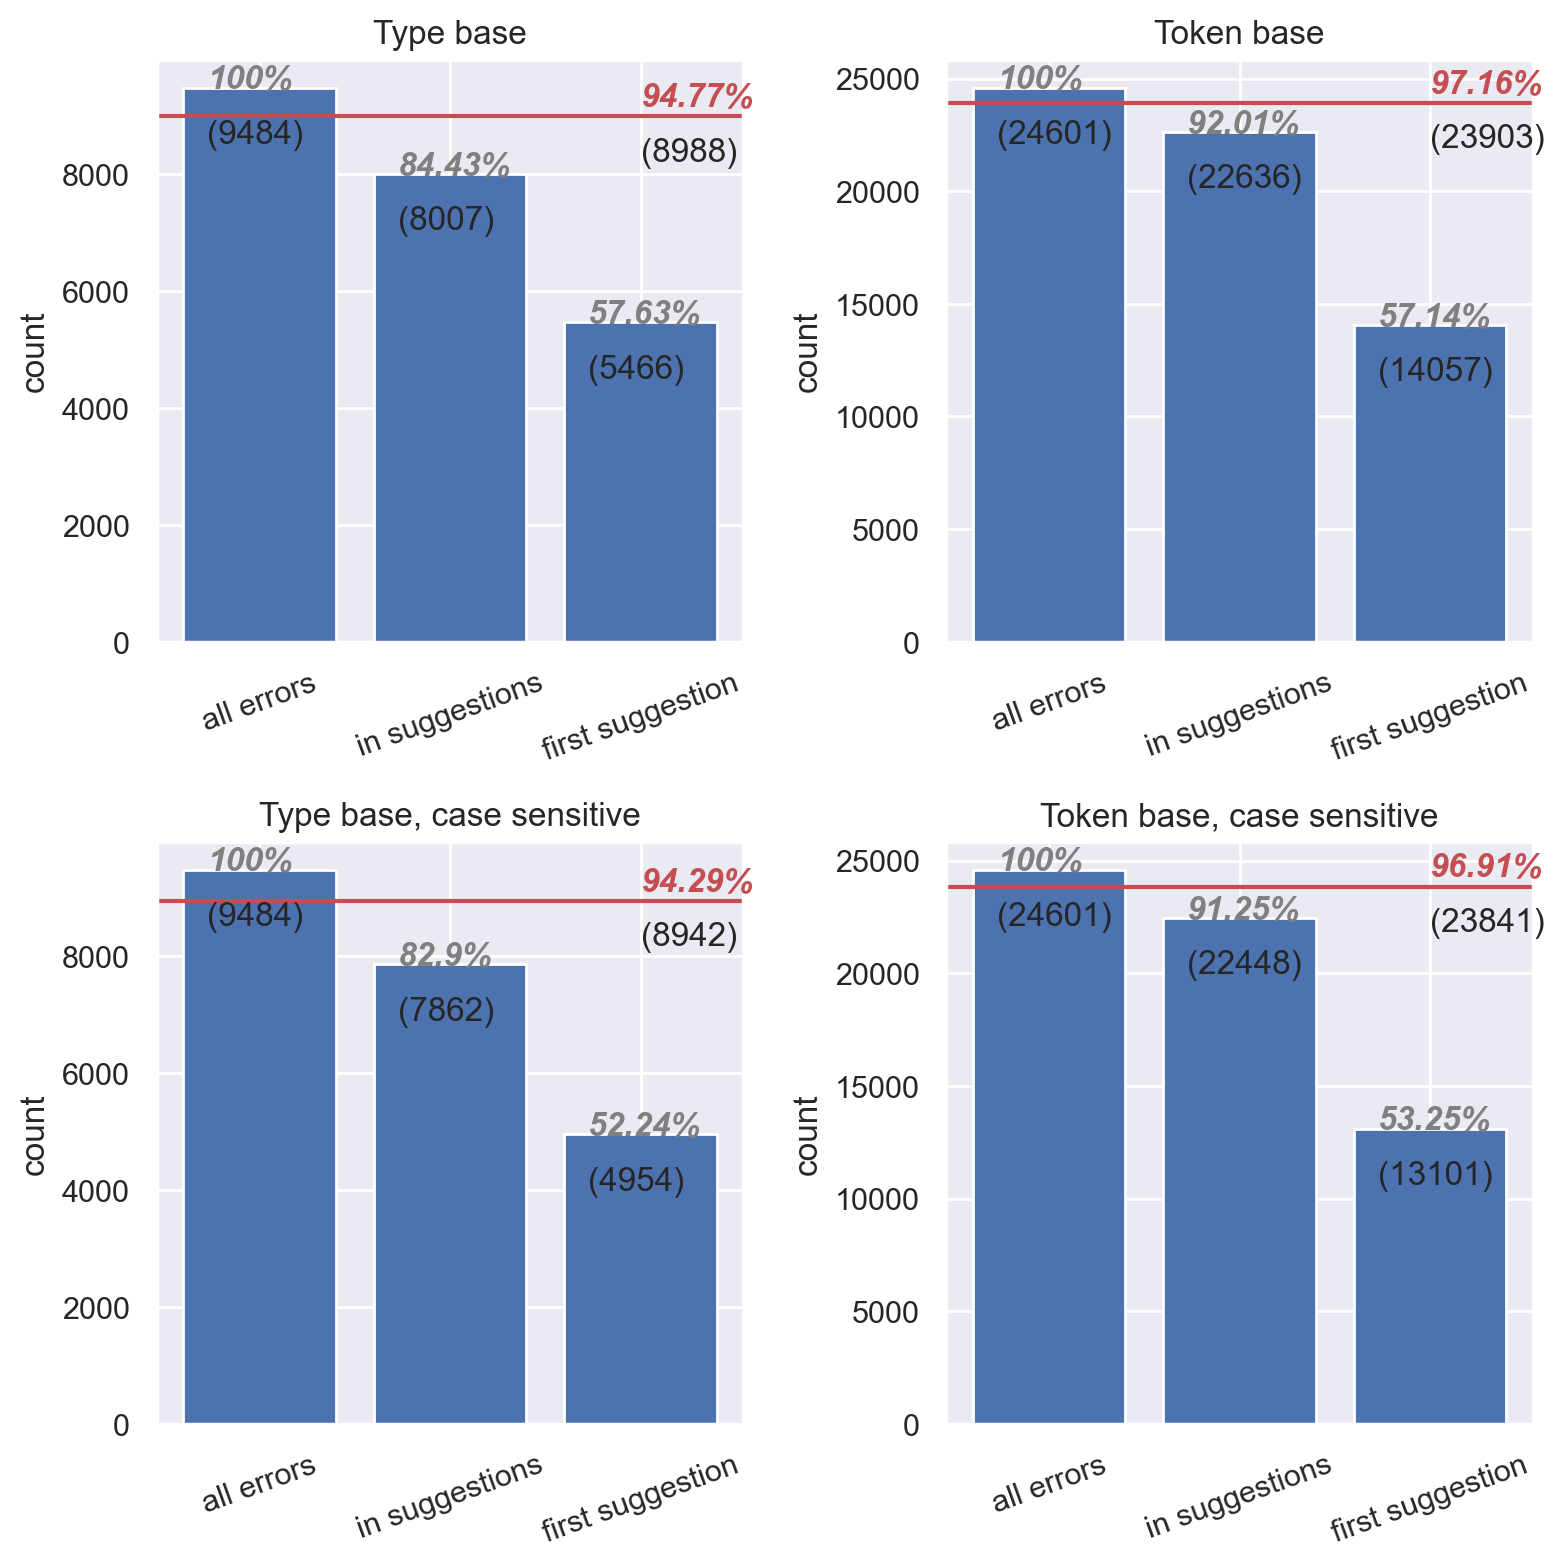

In [11]:
fig, axs = loop_plot(x_y_plots, ub_list)

# CONFIQ for each plot each

axs[0].set_title("Type base")
axs[1].set_title("Token base")

axs[2].set_title("Type base, case sensitive")
axs[3].set_title("Token base, case sensitive")

#plt.set_title("Spelling correction by hunspell (TYPE base)", fontweight='bold')
plt.tight_layout()
plt.show()

#### <span style='background : yellow' > Key message: </span>

- There are 9484 distinct missspellings (types base) to be analyzed.
- For 84% of types, Boyd finds any suggestions.
- For 58% of types, the correct target word is the first suggestion made by hunspell.

- (...) The upper bound value is 94% for types and 97% for tokens.

### Ratios

In [12]:
display(values_token[2]/values_token[0]) # first_sugg/all_token
display(values_token[2]/values_token[1]) # first_sugg/in_sugg

0.5713995366042031

0.6210019438063262

#### <span style='background : yellow' > Key message: </span>

- The ratio of tokens with index 0 towards all tokens is 57 % (see 2nd subplot).
    - From all error token, the correct word is first suggestion for 57% of tokens.
- The ratio of tokens with index 0 towards all tokens within suggestions is 62 %.
    - From all tokens with any suggestion, the correct words is first suggestion for 62% of these tokens.

In [13]:
# Wie viel Prozent pro Text werden auf Index 0 korrigiert? Das plotten
# Bar chart mit dieser einen Variable, das dann im Schnitt
# Nach oben schieben

# TODO: geeignete Darstellung
# TODO: index 0 Korrektur pro filename
# im Schnitt der Anteil der Index0 Korrekturen (idx = 0.0, idx0=True)
# in suggestions
# an allen Fehlern im Text (idx0=False)
# und dann Mittelwert: Wie oft im Schnitt pro Text richtige Korrektur?

# idx 0
# alle anderen fehler
# pro text

#sns.histplot(count_idx0, palette='Greens')
#sns.histplot(count_not_idx0, palette='Reds')

<a id='3'></a><br>
## 3 - Distributions (token base)
- Per Boyd suggestions (indices)
- Per testpoint

In [14]:
# PREPARATION
# How often is it not in suggestions at all? dummy index -1
data_error_token['sugg_idx'].fillna(-1, inplace=True)
data_error_types['sugg_idx'].fillna(-1, inplace=True)

In [15]:
display(data_error_token.sugg_idx.value_counts().sort_values(ascending=False))
display(data_error_types.sugg_idx.value_counts().sort_values(ascending=False))

 0.0    14057
 1.0     5066
-1.0     1965
 2.0     1580
 3.0      775
 4.0      352
 5.0      296
 6.0      193
 8.0      131
 7.0      117
 9.0       69
Name: sugg_idx, dtype: int64

 0.0    5466
-1.0    1477
 1.0    1017
 2.0     521
 3.0     293
 4.0     209
 5.0     141
 6.0     129
 7.0      89
 8.0      83
 9.0      59
Name: sugg_idx, dtype: int64

<a id='5'></a><br>
#### 1) Per Boyd suggestions (indices)

In [16]:
#sns.countplot(data_error_types.dict_index)
#sns.countplot(data_error_types[data_error_types.possible].dict_index)

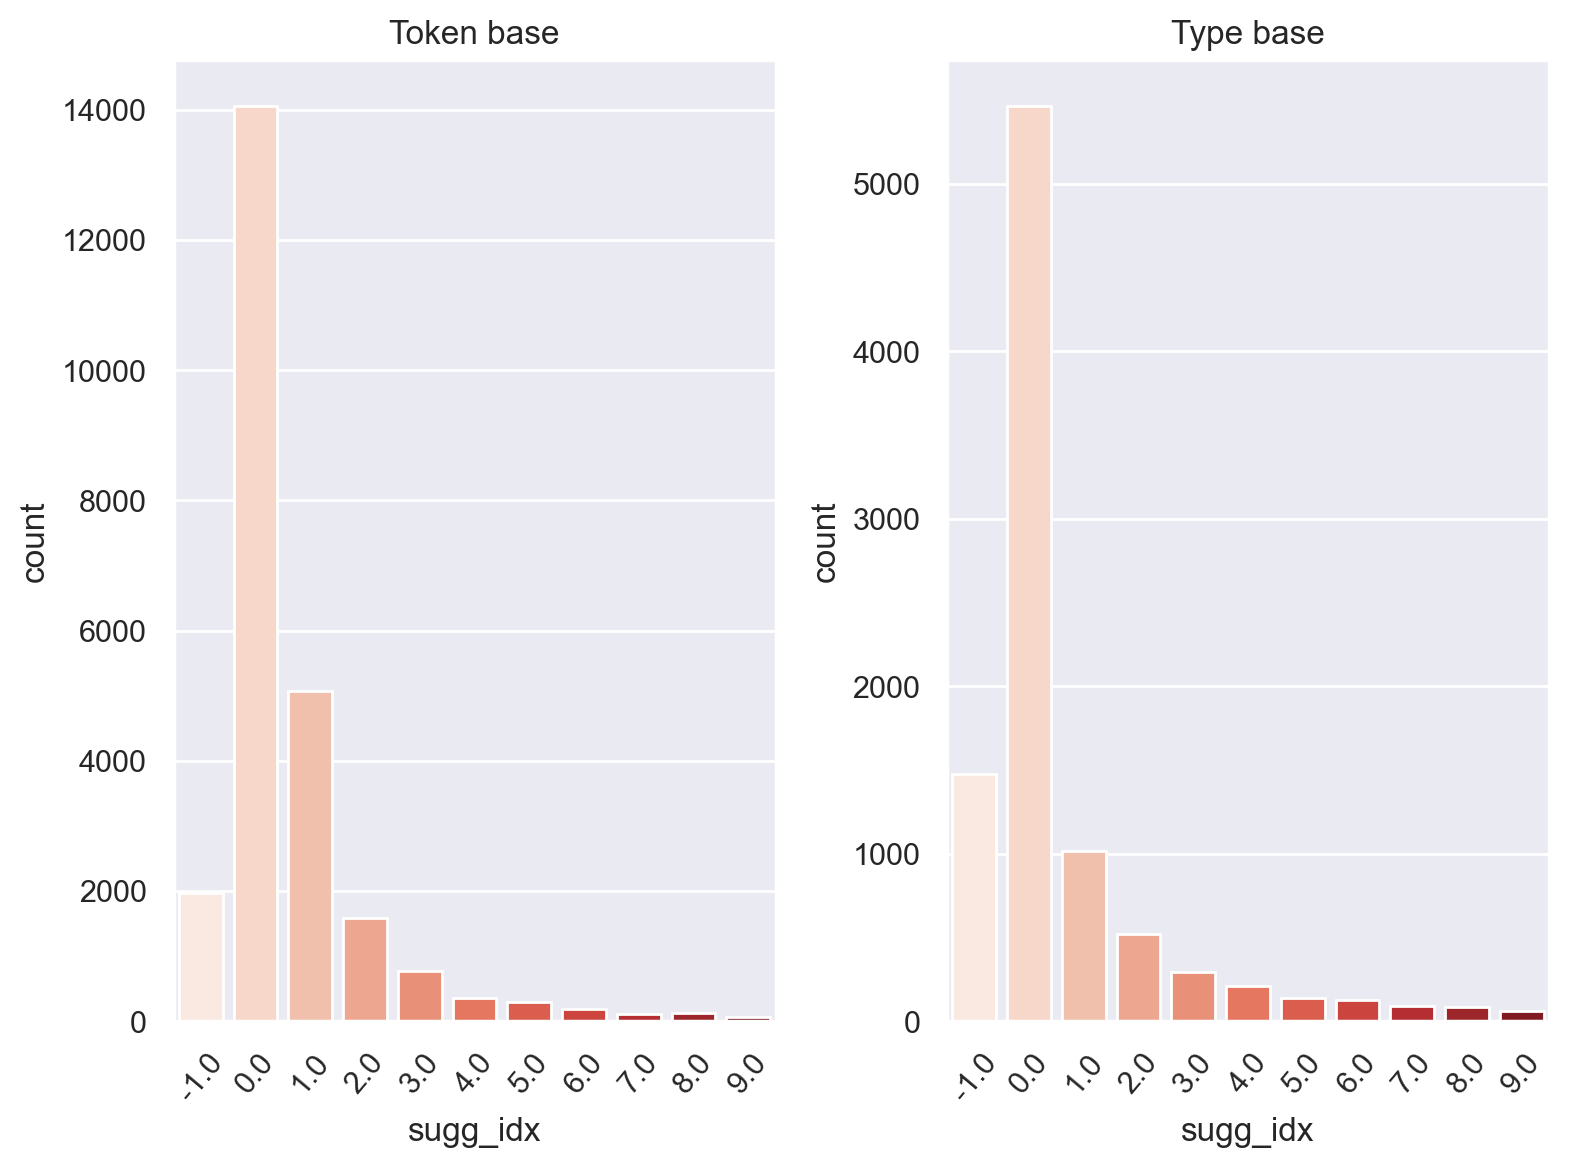

In [17]:
fig, axs = plt.subplots(1, 2)
#ax1 = fig.add_subplot(1, 2, 1)
#ax2 = fig.add_subplot(1, 2, 2)

sns.countplot(x='sugg_idx', data=data_error_token, palette='Reds', ax=axs[0])
sns.countplot(x='sugg_idx', data=data_error_types,  palette='Reds', ax=axs[1])

axs[0].set_title('Token base')
axs[1].set_title('Type base')

# Labels are wrong this way; Gives back labels in the wrong order
#axs[0].set_xticklabels(labels=list(data_error_token.sugg_idx.unique()), rotation=50)
#axs[1].set_xticklabels(labels=list(data_error_types.sugg_idx.unique()), rotation=50)

axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=50)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=50)

fig.tight_layout()

#### <span style='background : yellow' > Key message: </span>
- Compared to hunspell
    - Not any: 2000 vs 9000 token, 1500 vs 4000 types
    - idx0: 14000 vs 8000 token, 5250 vs 3250 types
    - idx1: 5000 vs 2250 token, 1000 vs 1000 types
    - rest "quite similar"

#### 2) Per testpoint

In [18]:
# test time point (01-10); It is firt number in filename
data_error_token['testpoint'] = data_error_token.filename.apply(lambda x: x.split('-')[0])

In [19]:
#sns.countplot(x='testpoint', data=data_error_token, palette="Blues")
#plt.show()

#### <span style='background : yellow' > Key message: </span>

<span style='background : yellow' > </span>

<a id='4'></a><br>
## 4 - Relationships

### Relationship: Suggestions index on testpoint
- Percent stacked bar plot
- Percent stacked bar plot, 3 categories


*Beforehand: <br>
Because there are so many indices of suggestions (0-14 and -1), values equal or above 5.0 are mapped to 5.0, so that there is a category ">= 5".*

In [20]:
# JFYI: What is on suggested index 14?
# data_error_token[data_error_token['sugg_idx'] == 14.0]

# Observation: Not in_dict but in suggestions anyways?
# Measure: New upper bound, i. e. hunspell corrects target words, what is recognized as (not) correct? Correct is upper bound

In [21]:
# MAPPING
# Summarize values; 0, 1, 2, 3, 4, 5+
# Has to be mapped to one value, i. e. 5
        
def map_idx_5(x):
    sugg_idx = x['sugg_idx']
    if sugg_idx in [5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]:
        return 5.0
    else:
        return sugg_idx
    
# Map categories and create new column for result
data_error_token['sugg_idx_5'] = data_error_token.apply(map_idx_5, axis=1)

#### 1) Percent stacked bar plot

In [22]:
# TODO: Modularize

# Get values: PERCENT STACKED BAR PLOT

# 1) Get counts for hue variable sugg_idx_5
def get_count_5(x, gb_var='testpoint'):
    return data_error_token[data_error_token.sugg_idx_5==x].groupby(gb_var).count().reset_index()

# 6
ct_non = get_count_5(-1)
ct_0 = get_count_5(0.0)
ct_1 = get_count_5(1.0)
ct_2 = get_count_5(2.0)
ct_3 = get_count_5(3.0)
ct_4 = get_count_5(4.0)
ct_5 = get_count_5(5.0)

In [23]:
# 2) Get totals, i. e. count for 100%
idx_5_total = [i+j+k+l+m+n+o for i,j,k,l,m,n,o in zip(ct_non['freq_ori'], ct_0['freq_ori'], ct_1['freq_ori'],
                                     ct_2['freq_ori'], ct_3['freq_ori'], ct_4['freq_ori'], ct_5['freq_ori'])] # list comprehension
display(idx_5_total)

[1716, 2154, 2028, 2520, 2527, 2924, 2900, 3046, 2549, 2237]

In [24]:
# 3) Get ratio of respective bars in percent, i. e. bar "length"
bars_ct_non = [i / j * 100 for i, j in zip(ct_non['freq_ori'], idx_5_total)]
bars_ct_0 = [i / j * 100 for i, j in zip(ct_0['freq_ori'], idx_5_total)]
bars_ct_1 = [i / j * 100 for i, j in zip(ct_1['freq_ori'], idx_5_total)]
bars_ct_2 = [i / j * 100 for i, j in zip(ct_2['freq_ori'], idx_5_total)]
bars_ct_3 = [i / j * 100 for i, j in zip(ct_3['freq_ori'], idx_5_total)]
bars_ct_4 = [i / j * 100 for i, j in zip(ct_4['freq_ori'], idx_5_total)]
bars_ct_5 = [i / j * 100 for i, j in zip(ct_5['freq_ori'], idx_5_total)]

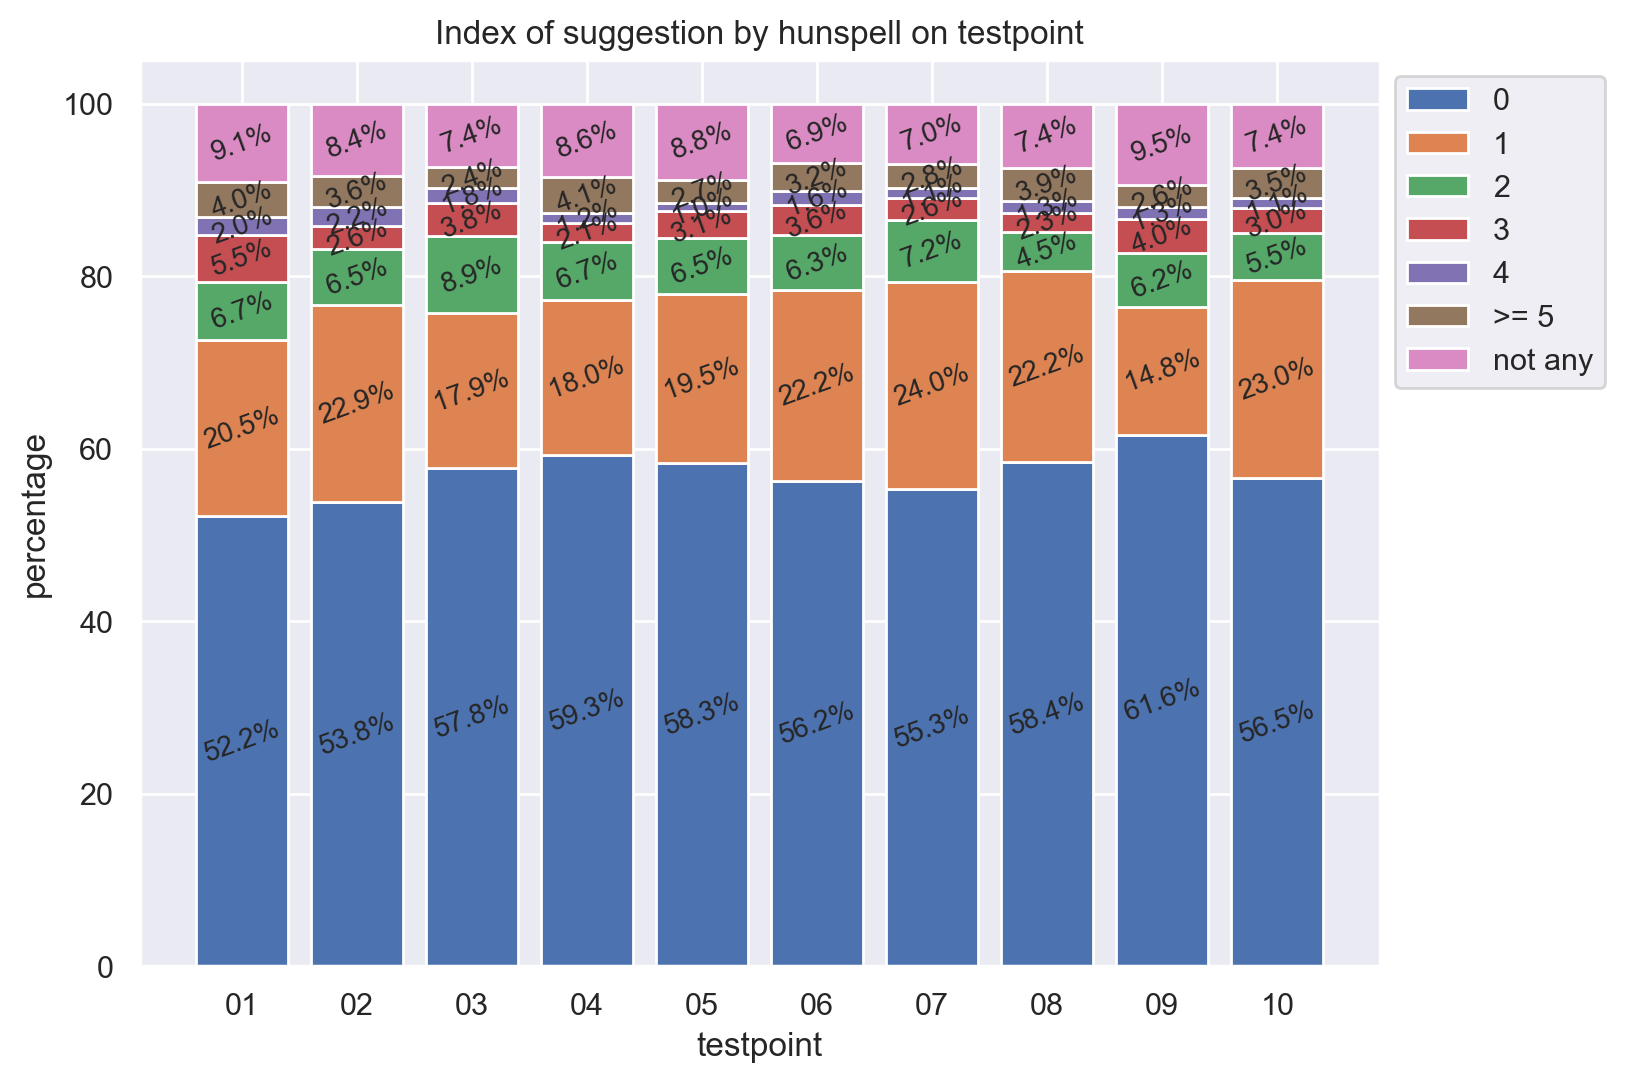

In [25]:
# TODO: Code schöner machen?!
# TODO: Percentages plotten...?
# PERCENT STACKED BAR PLOT

x_pos = np.arange(0,10) # position of x-ticks
x_lab = ct_non['testpoint']

fig = plt.figure()
axs = fig.add_subplot(1,1,1)
# Create bars
axs.bar(x_pos, bars_ct_0, bottom = 0, label='0') # index 0
axs.bar(x_pos, bars_ct_1, bottom=bars_ct_0, label='1') # index 1
axs.bar(x_pos, bars_ct_2, bottom=[i+j for i, j in zip(bars_ct_0,bars_ct_1)], label='2') 
axs.bar(x_pos, bars_ct_3, bottom=[i+j+k for i, j, k in zip(bars_ct_0,bars_ct_1, bars_ct_2)], label='3') 
axs.bar(x_pos, bars_ct_4, bottom=[i+j+k+l for i, j, k, l in zip(bars_ct_0,bars_ct_1, bars_ct_2, bars_ct_3)], label='4')
axs.bar(x_pos, bars_ct_5, bottom=[i+j+k+l+m for i, j, k, l, m in zip(bars_ct_0,bars_ct_1, bars_ct_2, bars_ct_3, bars_ct_4)], label='>= 5')
axs.bar(x_pos, bars_ct_non, bottom=[i+j+k+l+m+n for i, j, k, l, m, n in zip(bars_ct_0,bars_ct_1, bars_ct_2, bars_ct_3, bars_ct_4, bars_ct_5)], label='not any')

# Costum x-axis
axs.set_xticks(x_pos)
axs.set_xticklabels(x_lab)
axs.set_xlabel('testpoint')

axs.set_ylabel('percentage')

# Plot percentages
#for idx, (ct_ttl, pct_non, pct_0, pct_1) in enumerate(zip(suggs_total, bars_sugg_non, bars_sugg_0, bars_sugg_1)):
#    axs.text(idx, bars_sugg_0[idx]/2, str(round(pct_0,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
#    axs.text(idx, bars_sugg_0[idx]+(bars_sugg_1[idx]/2), str(round(pct_1,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
#    axs.text(idx, bars_sugg_0[idx]+bars_sugg_1[idx]+(bars_sugg_non[idx]/2), str(round(pct_non,1))+'%', va='center', ha='center', rotation=20, fontsize=10)

for idx, (ct_ttl, pct_non, pct_0, pct_1, pct_2, pct_3, pct_4, pct_5) in enumerate(zip(idx_5_total, bars_ct_non, bars_ct_0, bars_ct_1, bars_ct_2, bars_ct_3, bars_ct_4, bars_ct_5)):
    axs.text(idx, bars_ct_0[idx]/2, str(round(pct_0,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+(bars_ct_1[idx]/2), str(round(pct_1,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+bars_ct_1[idx]+(bars_ct_2[idx]/2), str(round(pct_2,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+bars_ct_1[idx]+bars_ct_2[idx]+(bars_ct_3[idx]/2), str(round(pct_3,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+bars_ct_1[idx]+bars_ct_2[idx]+bars_ct_3[idx]+(bars_ct_4[idx]/2), str(round(pct_4,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+bars_ct_1[idx]+bars_ct_2[idx]+bars_ct_3[idx]+bars_ct_4[idx]+(bars_ct_5[idx]/2), str(round(pct_5,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+bars_ct_1[idx]+bars_ct_2[idx]+bars_ct_3[idx]+bars_ct_4[idx]+bars_ct_5[idx]+(bars_ct_non[idx]/2), str(round(pct_non,1))+'%', va='center', ha='center', rotation=20, fontsize=10)

# Add a legend
axs.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

# Plot title
axs.set_title('Index of suggestion by hunspell on testpoint')

plt.show()

#### <span style='background : yellow' > Key message: </span>

For most of tokens,
- the suggestion is on index 0 (blue proportion)
- or suggestion is at second position (index 1, orange proportion).
    
    
In the course of time, it can be observed that... <br>
_..., see also below_

<a id='6'></a><br>
#### 2) Percent stacked bar plot, 3 categories

In [26]:
# Per testpoint, count of error at index 0 in contrast to all other errors
# alle anderen
# sugg_idx nicht gefunden?! -1
def map_idx_bin(x):
    sugg_idx = x['sugg_idx']
    if sugg_idx == 0.0:
        return 0.0
    elif sugg_idx in np.arange(1.0,15.0):
        return 1.0
    else:
        return sugg_idx

In [27]:
# Map categories
data_error_token['sugg_idx_three'] = data_error_token.apply(map_idx_bin, axis=1)
data_error_types['sugg_idx_three'] = data_error_types.apply(map_idx_bin, axis=1)

In [28]:
# TODO: Modularize
# Count of error tokens, i. e. freq_ori, for each category (-1; 0; 1)
suggs_non = data_error_token[data_error_token.sugg_idx_three==-1].groupby('testpoint').count().reset_index() # returns index, not testpoint as index
#display(suggs_non)
suggs_0 = data_error_token[data_error_token.sugg_idx_three==0].groupby('testpoint').count().reset_index()
#display(suggs_0)
suggs_1 = data_error_token[data_error_token.sugg_idx_three==1].groupby('testpoint').count().reset_index()
#display(suggs_1)

In [29]:
# Get total, i. e. count for 100%
suggs_total = [i+j+k for i,j,k in zip(suggs_non['freq_ori'], suggs_0['freq_ori'], suggs_1['freq_ori'])] # list comprehension
#display(suggs_total)

# Get ratio of respective bars in percent, i. e. bar "length"
bars_sugg_non = [i / j * 100 for i, j in zip(suggs_non['freq_ori'], suggs_total)]
bars_sugg_0 = [i / j * 100 for i, j in zip(suggs_0['freq_ori'], suggs_total)]
bars_sugg_1 = [i / j * 100 for i, j in zip(suggs_1['freq_ori'], suggs_total)]
#display(bars_sugg_non, bars_sugg_0, bars_sugg_1)

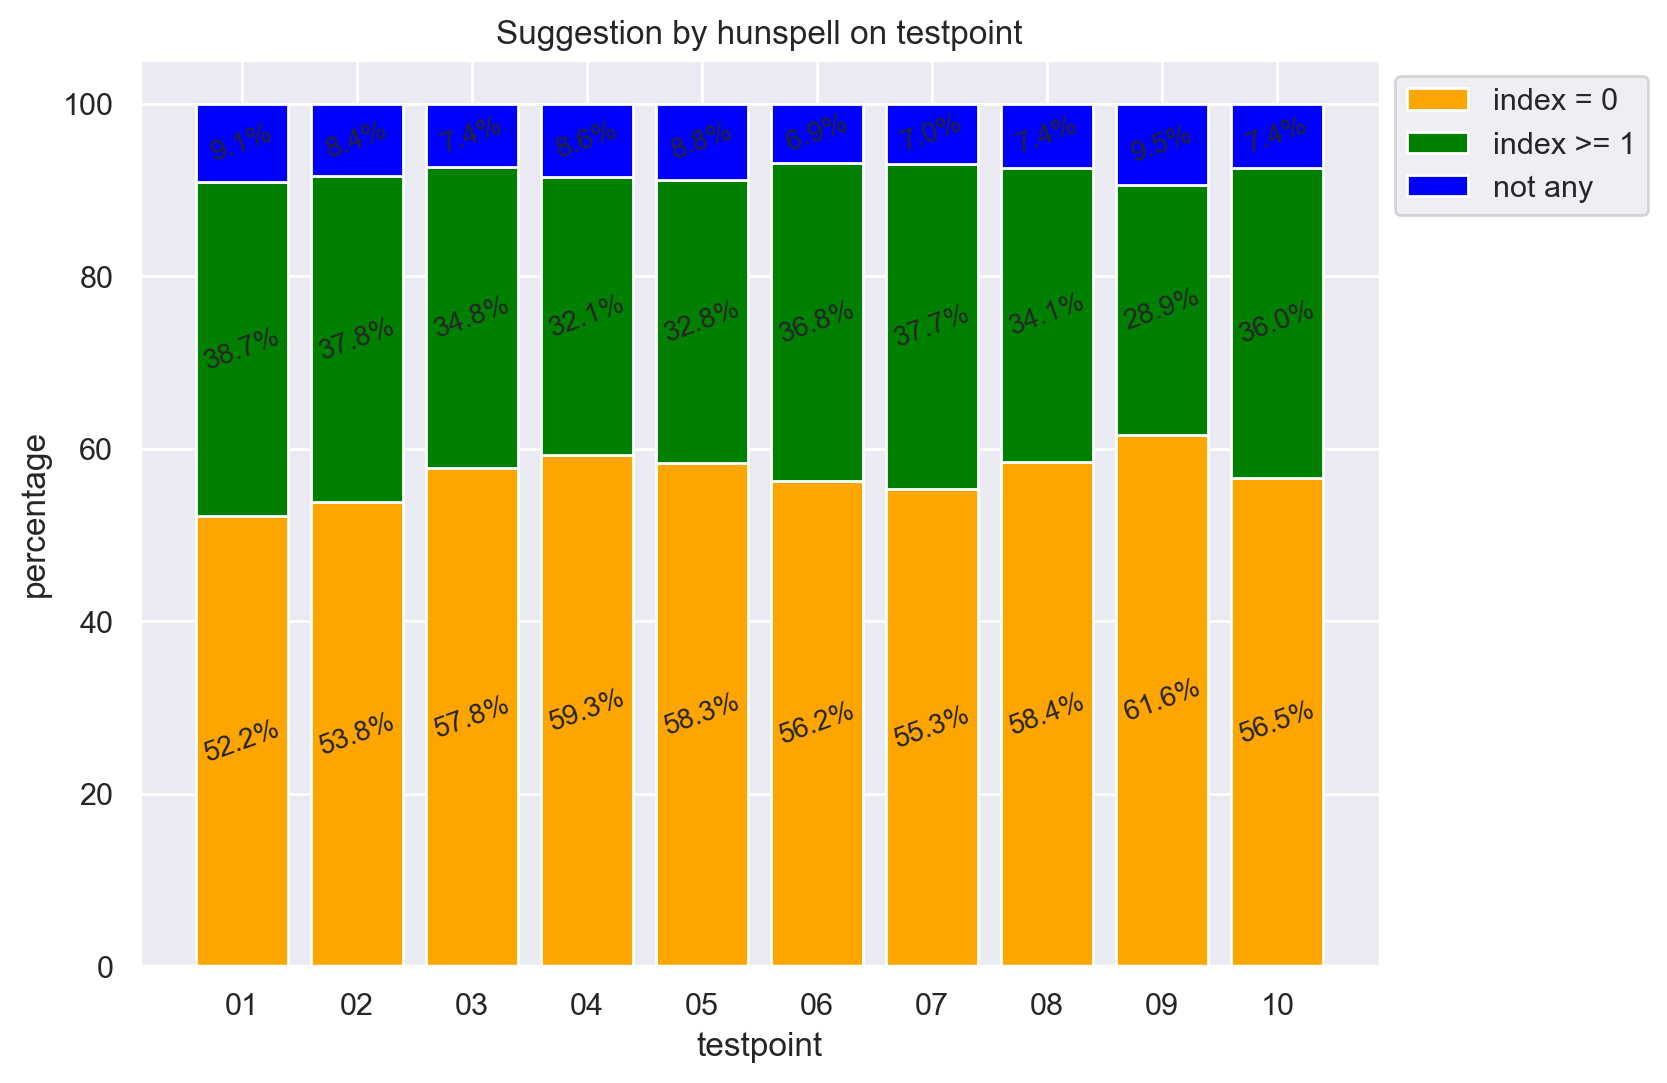

In [30]:
# PERCENT STACKED BAR PLOT

x_pos = np.arange(0,10) # position of x-ticks
x_lab = suggs_non['testpoint']

fig = plt.figure()
axs = fig.add_subplot(1,1,1)
# Create bars
axs.bar(x_pos, bars_sugg_0, bottom = 0, color='orange', label='index = 0') # index 0
axs.bar(x_pos, bars_sugg_1, bottom=bars_sugg_0, color='green', label='index >= 1') # index 1
axs.bar(x_pos, bars_sugg_non, bottom=[i+j for i, j in zip(bars_sugg_0,bars_sugg_1)], color='blue', label='not any') # noty any

# Costum x-axis
axs.set_xticks(x_pos)
axs.set_xticklabels(x_lab)
axs.set_xlabel('testpoint')

axs.set_ylabel('percentage')

# Plot percentages
for idx, (ct_ttl, pct_non, pct_0, pct_1) in enumerate(zip(suggs_total, bars_sugg_non, bars_sugg_0, bars_sugg_1)):
    axs.text(idx, bars_sugg_0[idx]/2, str(round(pct_0,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_sugg_0[idx]+(bars_sugg_1[idx]/2), str(round(pct_1,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_sugg_0[idx]+bars_sugg_1[idx]+(bars_sugg_non[idx]/2), str(round(pct_non,1))+'%', va='center', ha='center', rotation=20, fontsize=10)

# Add a legend
axs.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

# Plot title
axs.set_title('Suggestion by hunspell on testpoint')

plt.show()

In [31]:
# Get averages for testpoints 1-5 and 6-10
# Shares ordered by appereance in plot
shares = [bars_sugg_0, bars_sugg_1, bars_sugg_non]
helpers.print_AM_half_tp(shares)

56.26
57.63
********************
35.27
34.73
********************
8.47
7.64
********************


#### <span style='background : yellow' > Key message: </span>

<span style='background : yellow' > <br>
Trends to be observed...</span> 
- Portion of index 0 gets just slightly higher over time (rougly 56,3% to 57,6; increase 1,3%)
- Portion of indices above 0 decrease only slightly over time (from roughly 35,3% to 34,7%; decrease 0,6%)
- Portion of noty any decrease slightly over time (from 8,5% to 7,4%; decrease 1,1%)


Generally spoken:
- Portion of not any holds below one tenth (about 8%).


### Relationship: Levenshtein distance on testpoint
- Percent stacked bar plot

#### Get Levenshtein distance stats

In [32]:
from nltk.metrics.distance import edit_distance

data_error_types['edit_dst'] = data_error_types.apply(lambda r: edit_distance(r.original, r.corrected), axis=1)
data_error_token['edit_dst'] = data_error_token.apply(lambda r: edit_distance(r.original, r.corrected), axis=1)

In [33]:
# Due to preprocessing, there are some words with edit distance 0
#display(data_error_token[data_error_token['edit_dst']==0])
#display(data_error_types[data_error_types['edit_dst']==0])

# TODO: Wieso fliegen diese Sonderzeichen nicht raus
# Oben raussuchen unchanged_original != original_cs (eventuell auch Levenshtein distance >= 1)
# Diese Wörter rausschmeißen

In [34]:
# Map them to edit distance 1 for plotting of Levenshtein distance stats
data_error_token['edit_dst_0excl'] = data_error_token.edit_dst.apply(lambda x: 1 if x == 0 else x)
data_error_types['edit_dst_0excl'] = data_error_types.edit_dst.apply(lambda x: 1 if x == 0 else x)
#display(data_error_token[data_error_token['edit_dst_0excl']==0])
#display(data_error_types[data_error_types['edit_dst_0excl']==0])

In [35]:
# Map values above 4 to 4 to summarize categories with few counts
data_error_token['edit_dst_4'] = data_error_token.edit_dst_0excl.apply(lambda x: 4 if x in [5,6,7,8,9] else x)
data_error_types['edit_dst_4'] = data_error_types.edit_dst_0excl.apply(lambda x: 4 if x in [5,6,7,8,9] else x)
#data_error_token.head(10)

#### - Percent stacked bar plot

In [36]:
# Count of tokens for each category (1; 2; 3; 4)
ct_dst_1 = data_error_token[data_error_token.edit_dst_4==1].groupby('testpoint').count().reset_index() # returns index, not testpoint as index
#display(ct_dst_1)
ct_dst_2 = data_error_token[data_error_token.edit_dst_4==2].groupby('testpoint').count().reset_index()
#display(ct_dst_2)
ct_dst_3 = data_error_token[data_error_token.edit_dst_4==3].groupby('testpoint').count().reset_index()
#display(ct_dst_3)
ct_dst_4 = data_error_token[data_error_token.edit_dst_4==4].groupby('testpoint').count().reset_index()
#display(ct_dst_4)

In [37]:
# Get total, i. e. count for 100%
ct_dst_total = [i+j+k+l for i,j,k,l in zip(ct_dst_1['edit_dst_4'], ct_dst_2['edit_dst_4'], ct_dst_3['edit_dst_4'], ct_dst_4['edit_dst_4'])] # list comprehension

#display(ct_dst_total)

# Get ratio of respective bars in percent, i. e. bar "length"
ratio_dst_1 = [i / j * 100 for i, j in zip(ct_dst_1['edit_dst_4'], ct_dst_total)]
ratio_dst_2 = [i / j * 100 for i, j in zip(ct_dst_2['edit_dst_4'], ct_dst_total)]
ratio_dst_3 = [i / j * 100 for i, j in zip(ct_dst_3['edit_dst_4'], ct_dst_total)]
ratio_dst_4 = [i / j * 100 for i, j in zip(ct_dst_4['edit_dst_4'], ct_dst_total)]

#display(ratio_dst_1, ratio_dst_2, ratio_dst_3, ratio_dst_4)

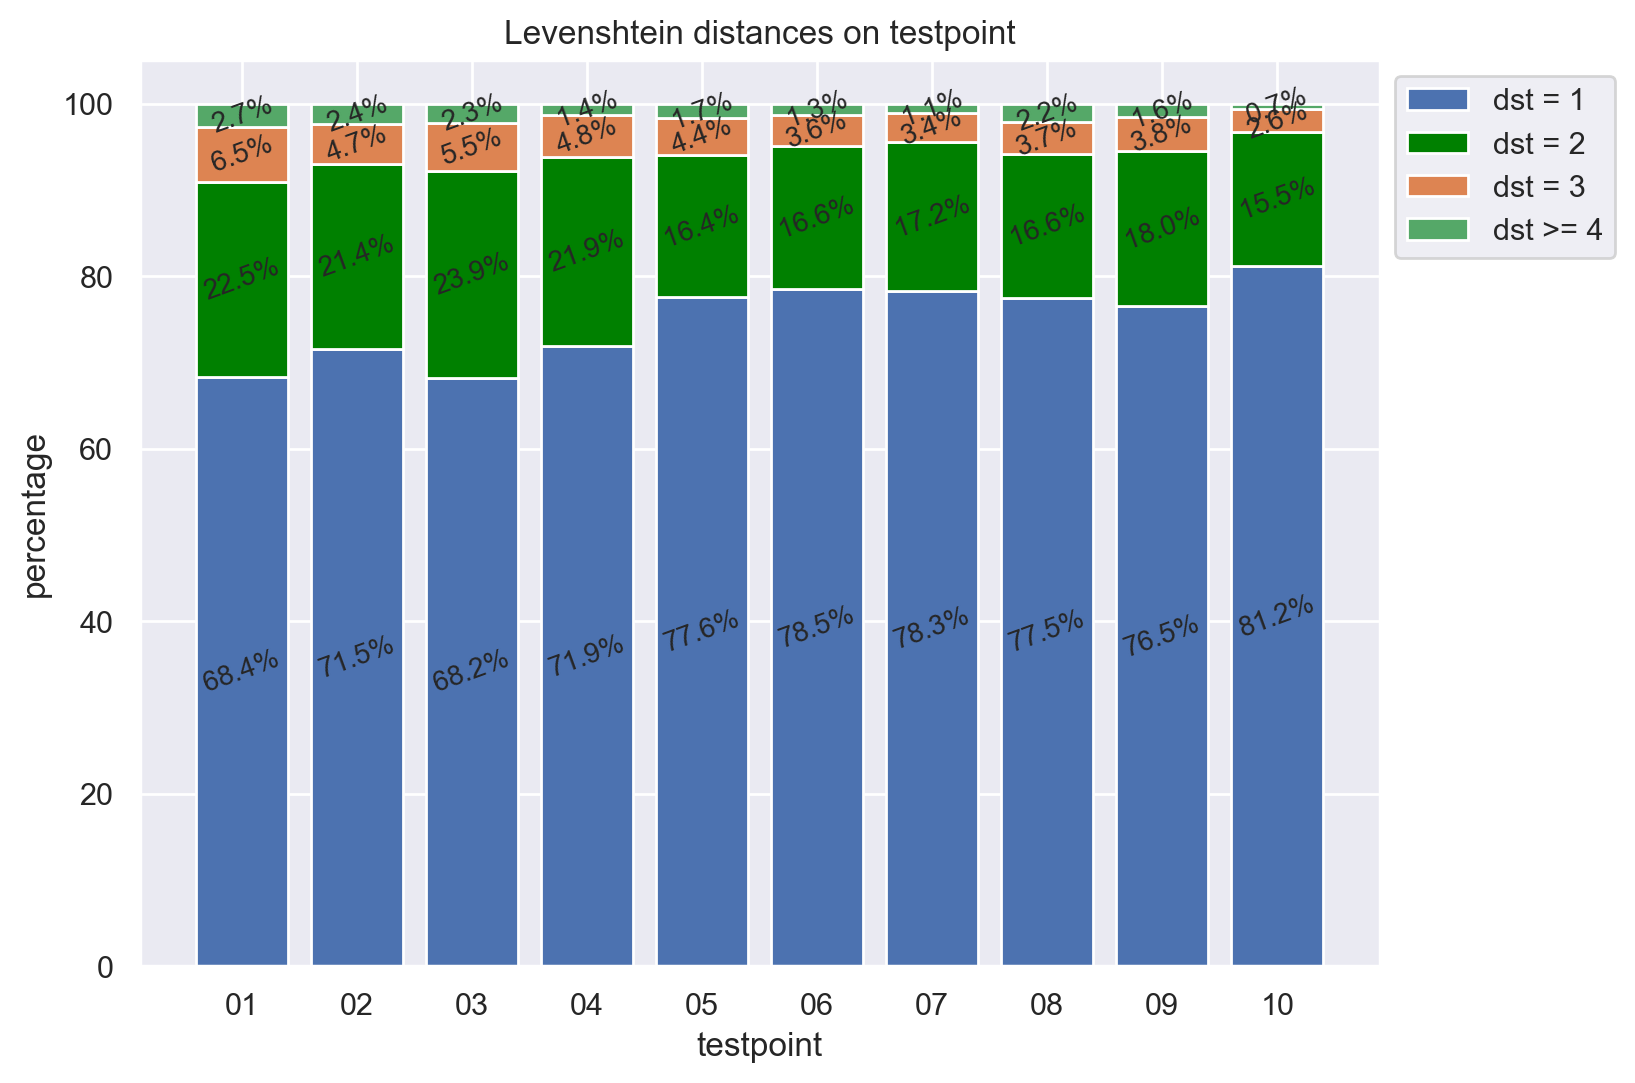

In [38]:
# TODO: Rule of three: Percent stacked bar plot over testpoints as function
# PERCENT STACKED BAR PLOT

x_pos = np.arange(0,10) # position of x-ticks
x_lab = suggs_non['testpoint']

fig = plt.figure()
axs = fig.add_subplot(1,1,1)

# Create bars; Modify
axs.bar(x_pos, ratio_dst_1, bottom = 0, label='dst = 1') # index 0
axs.bar(x_pos, ratio_dst_2, bottom = ratio_dst_1, color='green', label='dst = 2') # index 1
axs.bar(x_pos, ratio_dst_3, bottom=[i+j for i, j in zip(ratio_dst_1,ratio_dst_2)], label='dst = 3') # noty any
axs.bar(x_pos, ratio_dst_4, bottom=[i+j+k for i, j, k in zip(ratio_dst_1,ratio_dst_2,ratio_dst_3)], label='dst >= 4') # noty any

# Costum x-axis
axs.set_xticks(x_pos)
axs.set_xticklabels(x_lab)
axs.set_xlabel('testpoint')

axs.set_ylabel('percentage')

# Plot percentages; Modify
for idx, (ct_ttl, rt_1, rt_2, rt_3, rt_4) in enumerate(zip(ct_dst_total, ratio_dst_1, ratio_dst_2, ratio_dst_3, ratio_dst_4)):
    axs.text(idx, ratio_dst_1[idx]/2, str(round(rt_1,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, ratio_dst_1[idx]+(ratio_dst_2[idx]/2), str(round(rt_2,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, ratio_dst_1[idx]+ratio_dst_2[idx]+(ratio_dst_3[idx]/2), str(round(rt_3,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, ratio_dst_1[idx]+ratio_dst_2[idx]+ratio_dst_3[idx]+(ratio_dst_4[idx]/2), str(round(rt_4,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
                                                       
# Add a legend
axs.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

# Plot title
axs.set_title('Levenshtein distances on testpoint')

plt.show()

In [39]:
ratios_dst = [ratio_dst_1, ratio_dst_2, ratio_dst_3, ratio_dst_4]
helpers.print_AM_half_tp(ratios_dst)

71.52
78.4
********************
21.22
16.81
********************
5.17
3.43
********************
2.08
1.37
********************


#### <span style='background : yellow' > Key message: </span>

<span style='background : yellow' > <br>
Trends to be observed ...</span>

- By far, most of the missspellings have an edit distance of 1; It is about 70 to 80%, i.e. roughly 4/5; **Proportion increases** by 6% in AM
- Edit distance of 2 is aroung 20 to 15%, i.e. roughly under 1/5; **Proportion decreases** by 4% in AM
- Edit distance 3 is around or under 5%; **Proportion decreases** by 1,8% in AM
- Edit distance above equals 4 is around 3 to 1%; **Proportion decreases** by 0,7% in AM

<a id='7'></a><br>
### Relationship: Suggestions index on Levenshtein distance
- Percent stacked bar plot

#### - Percent stacked bar plot

In [40]:
def get_count_zero(x, gb_var='edit_dst_4'):
    grouped = data_error_token[data_error_token.sugg_idx_5==x].groupby(gb_var).count()
    # From edit-distance 2 on, there are zero values for the categories (index of suggestions) that are not counted by count
    # Therefore zero counts have to be added manually
    added_zero_values = grouped.reindex(data_error_token.edit_dst_4.unique()).fillna(0).astype(int)
    return added_zero_values.reset_index()

In [41]:
# TODO: Modularize
# 1) Get counts for each category (-1; 0; 1; 2; 3; 4; 5)
# Function see above
ct_non = get_count_zero(-1, gb_var='edit_dst_4')
ct_0 = get_count_zero(0.0, gb_var='edit_dst_4')
ct_1 = get_count_zero(1.0, gb_var='edit_dst_4')
ct_2 = get_count_zero(2.0, gb_var='edit_dst_4')
ct_3 = get_count_zero(3.0, gb_var='edit_dst_4')
ct_4 = get_count_zero(4.0, gb_var='edit_dst_4')
ct_5 = get_count_zero(5.0, gb_var='edit_dst_4')
#display(ct_non)

In [42]:
# 2) Get total, i. e. count for 100%
ct_total_2 = [i+j+k+l+m+n+o for i,j,k,l,m,n,o in zip(ct_non['sugg_idx_5'], ct_0['sugg_idx_5'], ct_1['sugg_idx_5'],
                                                   ct_2['sugg_idx_5'], ct_3['sugg_idx_5'], ct_4['sugg_idx_5'], ct_5['sugg_idx_5'])]
#display(ct_total_2)

In [43]:
# 3) Get ratio of respective bars in percent, i. e. bar "length"
bars_ct_non = [i / j * 100 for i, j in zip(ct_non['sugg_idx_5'], ct_total_2)]
bars_ct_0 = [i / j * 100 for i, j in zip(ct_0['sugg_idx_5'], ct_total_2)]
bars_ct_1 = [i / j * 100 for i, j in zip(ct_1['sugg_idx_5'], ct_total_2)]
bars_ct_2 = [i / j * 100 for i, j in zip(ct_2['sugg_idx_5'], ct_total_2)]
bars_ct_3 = [i / j * 100 for i, j in zip(ct_3['sugg_idx_5'], ct_total_2)]
bars_ct_4 = [i / j * 100 for i, j in zip(ct_4['sugg_idx_5'], ct_total_2)]
bars_ct_5 = [i / j * 100 for i, j in zip(ct_5['sugg_idx_5'], ct_total_2)]
#display(bars_ct_non)

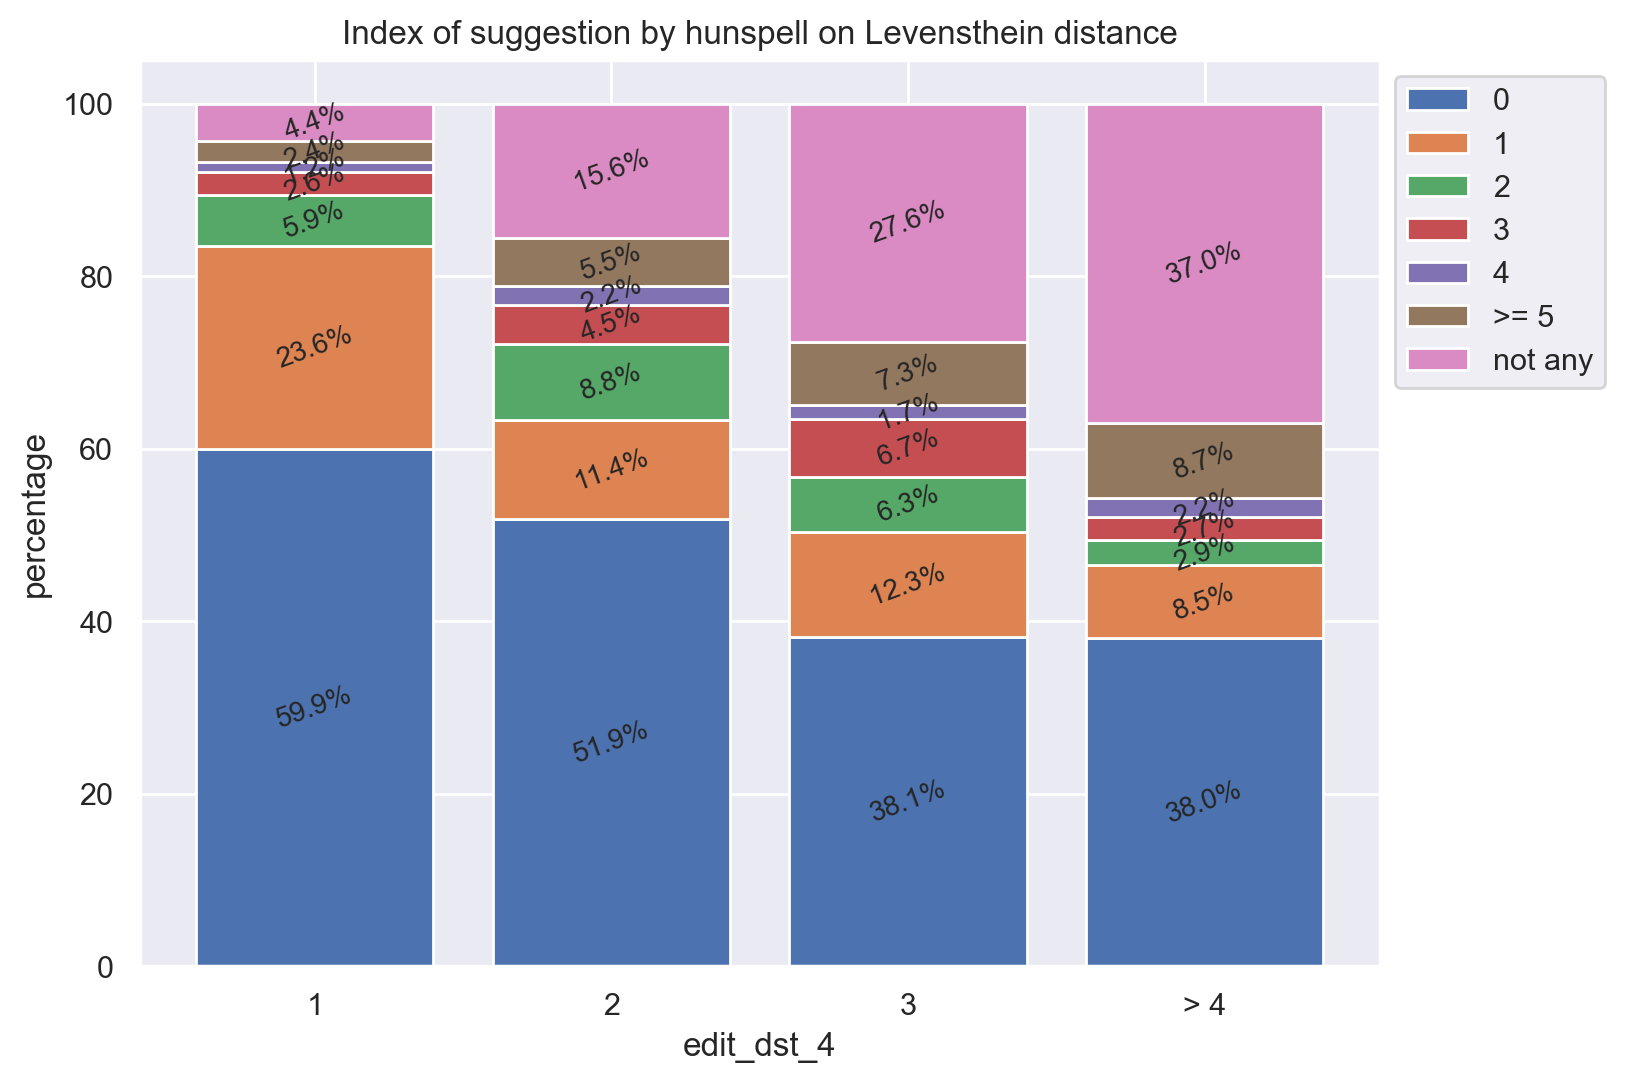

In [44]:
# PERCENT STACKED BAR PLOT

x_pos = np.arange(0,4) # position of x-ticks
#x_lab = ct_non['edit_dst_4']

fig = plt.figure()
axs = fig.add_subplot(1,1,1)

# Create bars
axs.bar(x_pos, bars_ct_0, bottom = 0, label='0') # index 0
axs.bar(x_pos, bars_ct_1, bottom=bars_ct_0, label='1') # index 1
axs.bar(x_pos, bars_ct_2, bottom=[i+j for i, j in zip(bars_ct_0,bars_ct_1)], label='2') 
axs.bar(x_pos, bars_ct_3, bottom=[i+j+k for i, j, k in zip(bars_ct_0,bars_ct_1, bars_ct_2)], label='3') 
axs.bar(x_pos, bars_ct_4, bottom=[i+j+k+l for i, j, k, l in zip(bars_ct_0,bars_ct_1, bars_ct_2, bars_ct_3)], label='4')
axs.bar(x_pos, bars_ct_5, bottom=[i+j+k+l+m for i, j, k, l, m in zip(bars_ct_0,bars_ct_1, bars_ct_2, bars_ct_3, bars_ct_4)], label='>= 5')
axs.bar(x_pos, bars_ct_non, bottom=[i+j+k+l+m+n for i, j, k, l, m, n in zip(bars_ct_0,bars_ct_1, bars_ct_2, bars_ct_3, bars_ct_4, bars_ct_5)], label='not any')

# Costum x-axis
axs.set_xticks(x_pos)
axs.set_xticklabels(['1','2','3','> 4'])
axs.set_xlabel('edit_dst_4')

axs.set_ylabel('percentage')

# Plot percentages
for idx, (ct_ttl, pct_non, pct_0, pct_1, pct_2, pct_3, pct_4, pct_5) in enumerate(zip(ct_total_2, bars_ct_non, bars_ct_0, bars_ct_1, bars_ct_2, bars_ct_3, bars_ct_4, bars_ct_5)):
    axs.text(idx, bars_ct_0[idx]/2, str(round(pct_0,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+(bars_ct_1[idx]/2), str(round(pct_1,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+bars_ct_1[idx]+(bars_ct_2[idx]/2), str(round(pct_2,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+bars_ct_1[idx]+bars_ct_2[idx]+(bars_ct_3[idx]/2), str(round(pct_3,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+bars_ct_1[idx]+bars_ct_2[idx]+bars_ct_3[idx]+(bars_ct_4[idx]/2), str(round(pct_4,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+bars_ct_1[idx]+bars_ct_2[idx]+bars_ct_3[idx]+bars_ct_4[idx]+(bars_ct_5[idx]/2), str(round(pct_5,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    axs.text(idx, bars_ct_0[idx]+bars_ct_1[idx]+bars_ct_2[idx]+bars_ct_3[idx]+bars_ct_4[idx]+bars_ct_5[idx]+(bars_ct_non[idx]/2), str(round(pct_non,1))+'%', va='center', ha='center', rotation=20, fontsize=10)
    
# Add a legend
axs.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

# Plot title
axs.set_title('Index of suggestion by hunspell on Levensthein distance')

plt.show()

#### <span style='background : yellow' > Key message: </span>

<span style='background : yellow' >  <br>
Trends to be observed ...</span>
- Boyd catches 96% of tokens with edit distance of 1, 60% are on index 0 (resulting in proportion at about 62,5%)
- Boyd catches 84% of tokens with edit distance of 2, 52% are on index 0 (resulting in proportion at about 61,9%)
- Boyd catches at about 70% of tokens with edit distance of 3, 38% are on index 0 (resulting in proportion at about 54,3%)
- Boyd catches about 60% of tokens with edit distance of 4, 38% are on index 0 (resulting in proportion at about 63,3%) 

In [45]:
# TODO: Percent stacked bar plot, 3 categories
# with edit_dst_4 & sugg_idx_three